In [53]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm,LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
from functions import compute_ivt,to_nc
from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation
from IPython import display
import proplot as pplt

In [3]:
year = 2014

In [4]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [5]:
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['day'], variable_id=['hus','va'], member_id=['r1i1p1f1'])

In [7]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [8]:
dataset_list = list(dset_dict.keys())

In [9]:
dset = dset_dict[dataset_list[0]]
dset = dset.sel(member_id='r1i1p1f1',time=slice(str(year)+"-01-01", str(year)+"-12-31"))

In [10]:
vas = dset.va
hus = dset.hus
plev = dset.plev
lat_ = hus.lat
lon_ = hus.lon

In [11]:
ivt = compute_ivt(hus,vas,plev)
dset.close()

In [12]:
ivt_ns = ivt.copy()
ivt_ns = xr.where(ivt_ns.lat<0,-ivt_ns,ivt_ns,True) # minus for southern hemisphere (positive toward the pole)
ivt_ns_pos = xr.where(ivt_ns<0,ivt_ns*0,ivt_ns,True) # negative values = not poleward

In [13]:
# pre-computed 98th percentile IVT
q98 = xr.open_dataset('q93_2000.nc')
q98 = q98.rename({'__xarray_dataarray_variable__':'ivt'})

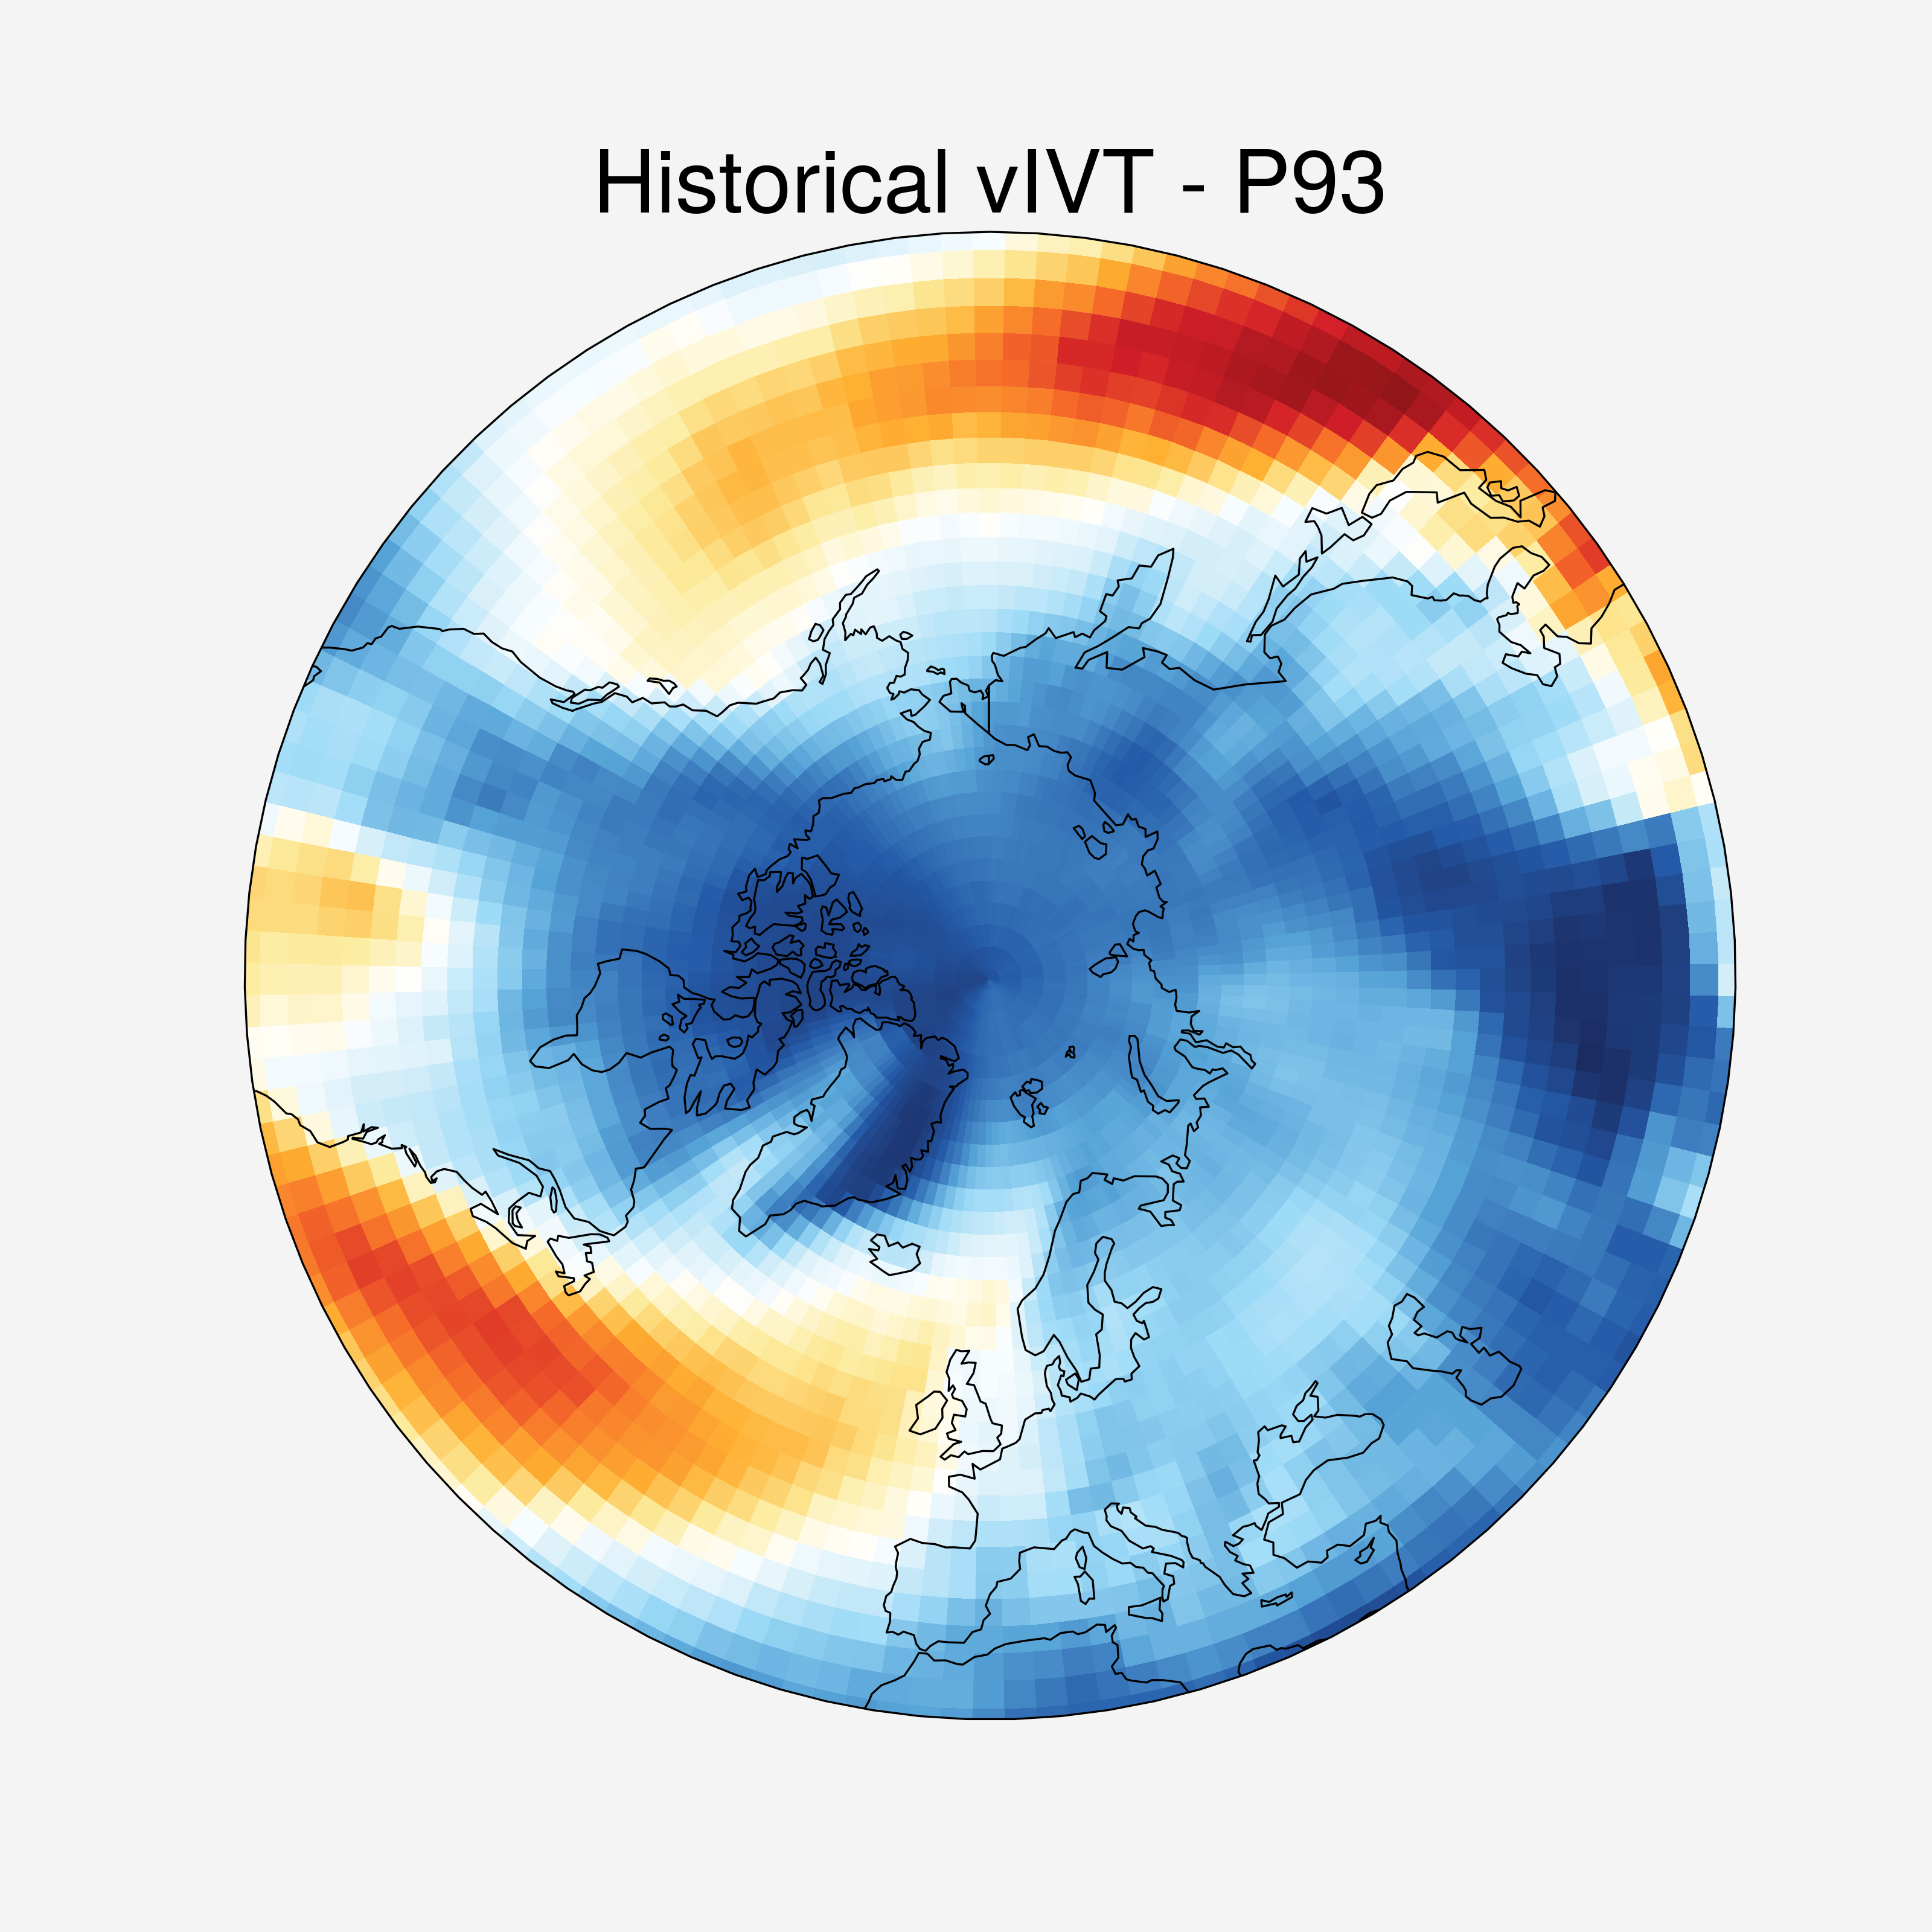

In [50]:
q98ns = q98.sel(lat=slice(30,90))
#q98s = q98.sel(lat=slice(-90,-30))

fig = plt.figure(figsize=(8,8),dpi=200)

ax1 = plt.subplot(1,1,1,projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180,180,31,90], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(0.5,0.5,0.5,0))
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)

cax1 = ax1.pcolormesh(q98ns.lon,q98ns.lat,q98ns.ivt,transform=ccrs.PlateCarree(),
                      cmap='ColdHot')
#cbar = plt.colorbar(cax1)
ax1.set_title('Historical vIVT - P93',size=26)
plt.show()

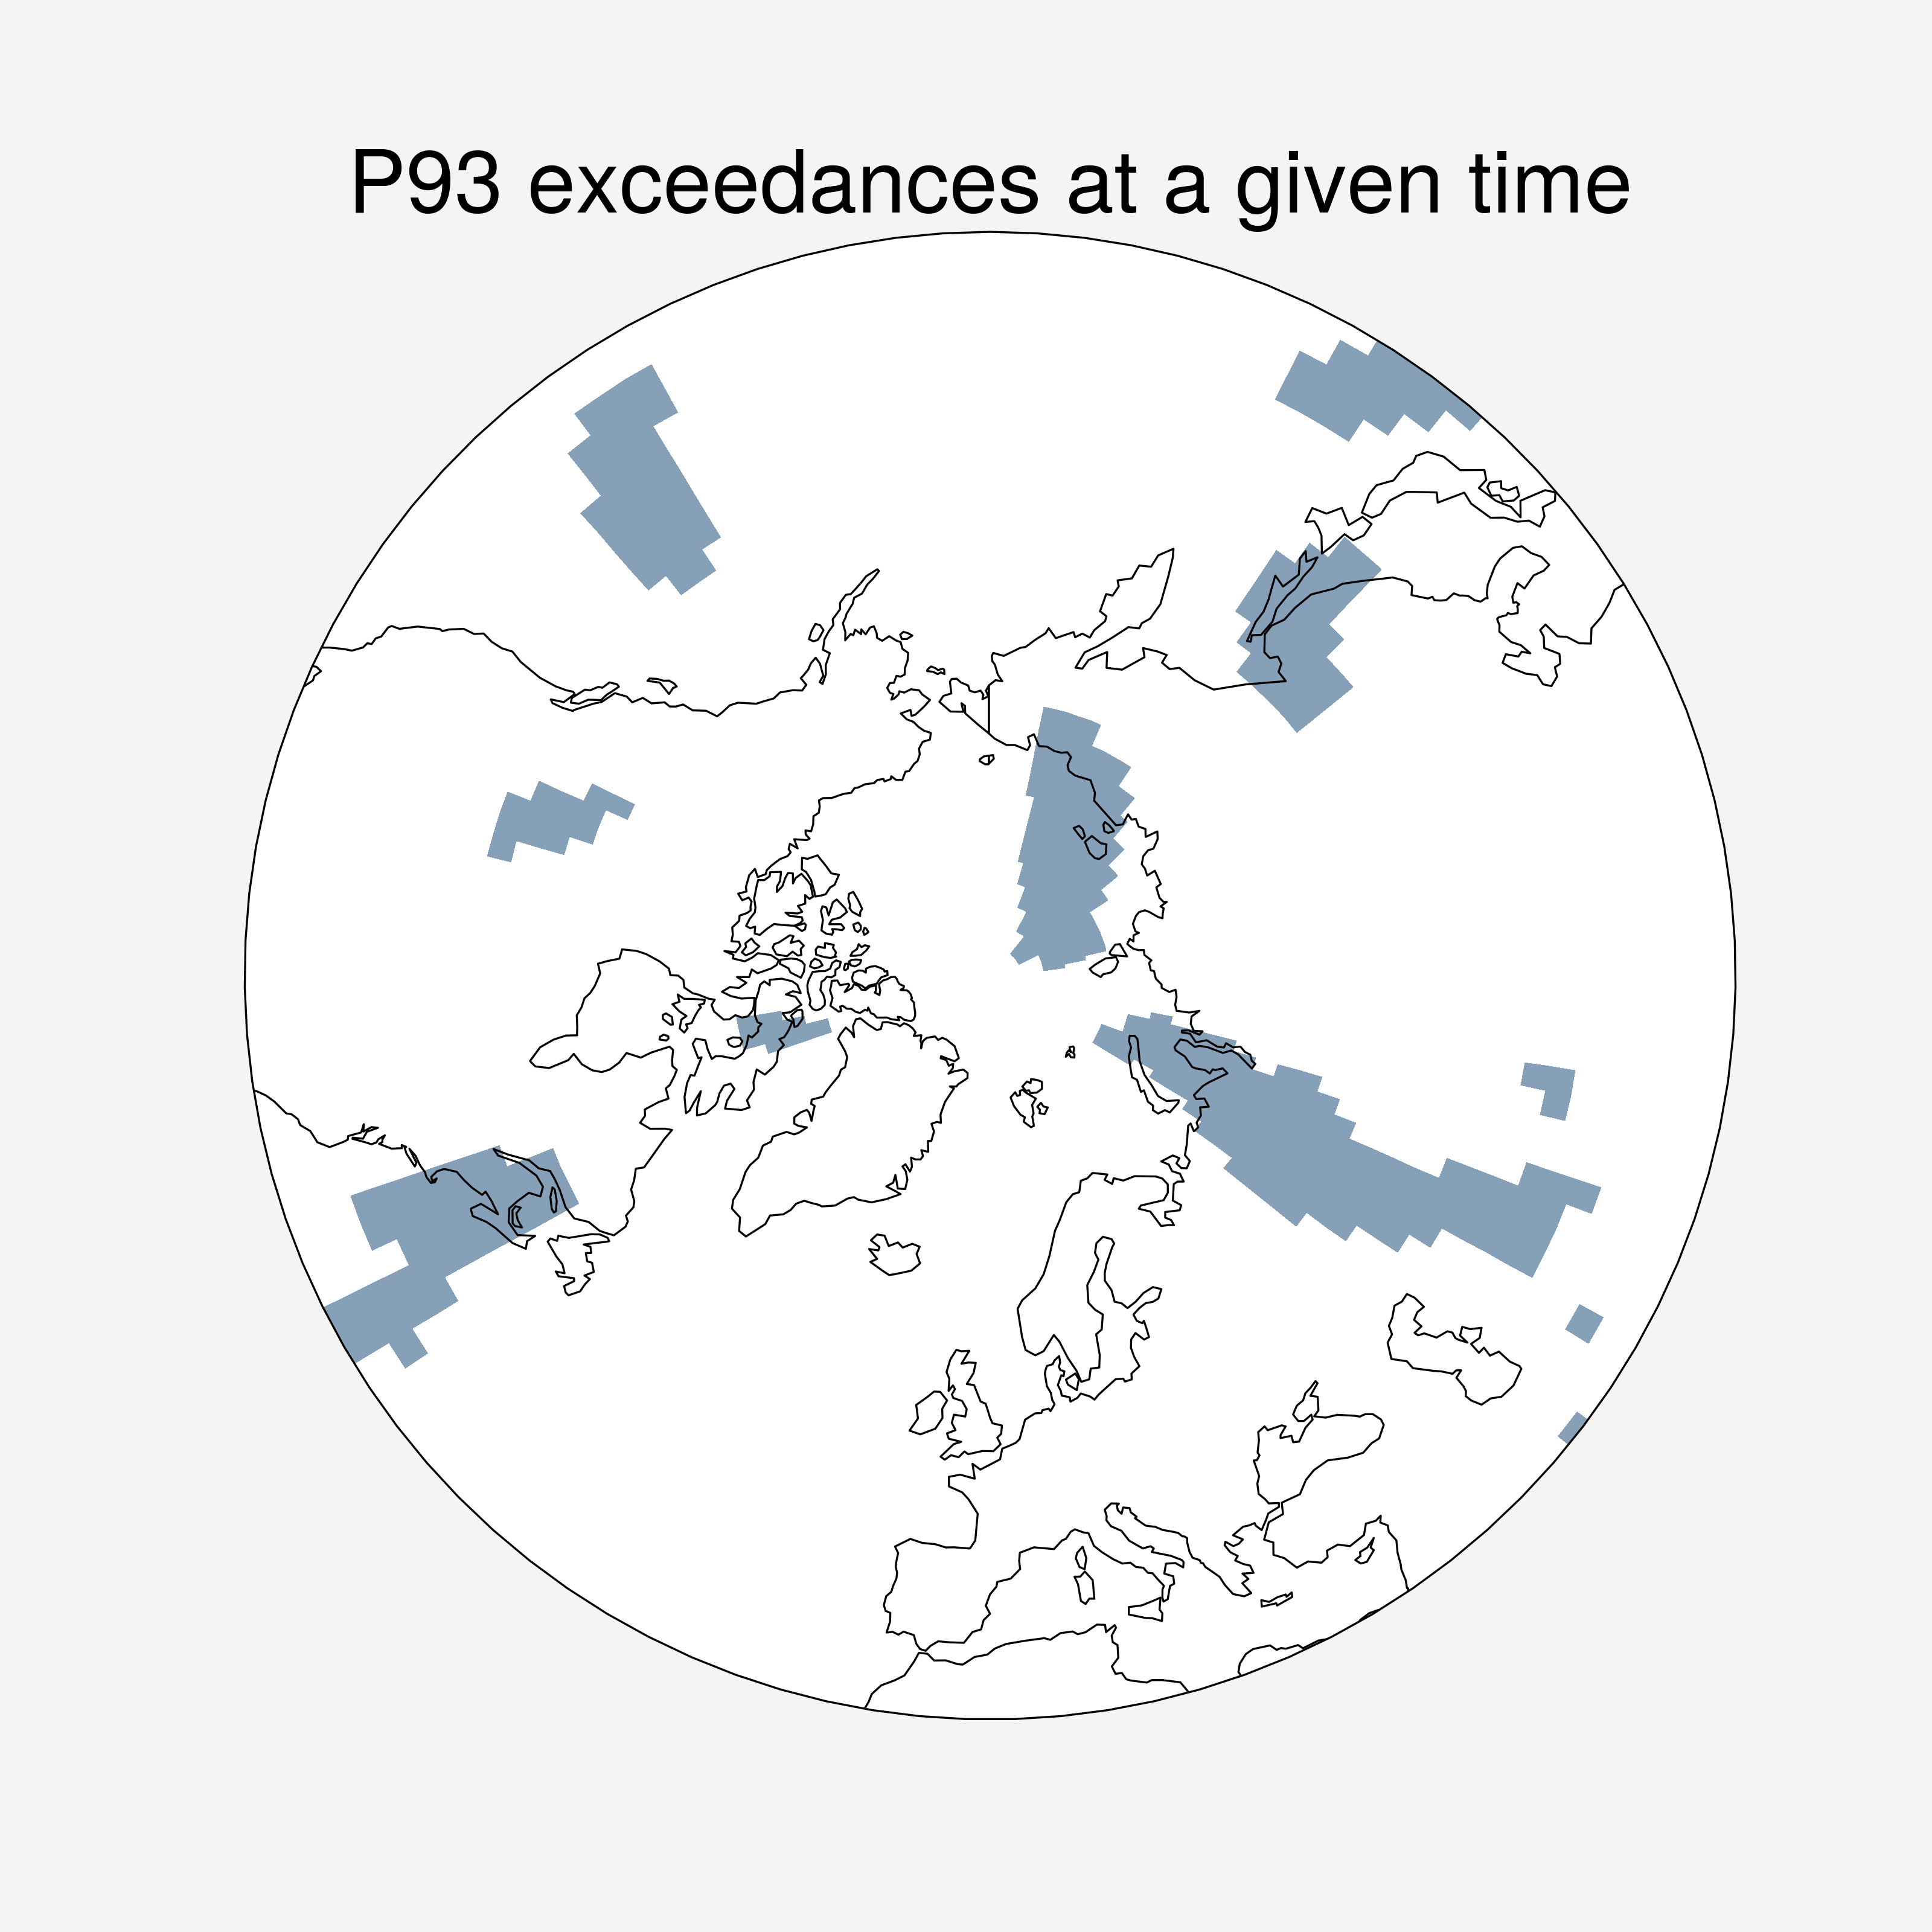

In [55]:
excess = ivt_ns_pos-q98
ar_points = xr.where(excess>0,1,0)
ar_points = ar_points.sel(time=slice('2014-06-01','2014-06-01'))

fig = plt.figure(figsize=(8,8),dpi=200)

ax1 = plt.subplot(1,1,1,projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180,180,31,90], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(0.5,0.5,0.5,0))
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)

cmap = LinearSegmentedColormap.from_list('testCmap', [(1,1,1,1),(134/255.,161/255.,183/255.,1)], N=2)

cax1 = ax1.pcolormesh(ar_points.lon,ar_points.lat,ar_points.ivt.values[:,0,:],transform=ccrs.PlateCarree(),cmap=cmap)
#cbar = plt.colorbar(cax1)
ax1.set_title('P93 exceedances at a given time',size=26)
plt.show()


q98.close()
ivt_ns_pos.close()

ar_points = xr.where(excess>0,1,0)

In [14]:
out_ar = ar_points.copy()
ar_points.close()

out_ar = out_ar.drop_vars(['quantile','member_id'])

out_loc = np.zeros((out_ar.ivt.shape[0],out_ar.ivt.shape[1],out_ar.ivt.shape[2])).astype(int)

res_lon = abs(lon_.values[1]-lon_.values[0])
res_lat = abs(np.min(np.diff(lat_.values)))

test_val = out_ar.ivt.values[:]

for tt in range(len(out_ar.time)):
    df_loc = test_val[:,tt,:]
    ll = plt.contour(df_loc,levels=[0,1])
    plt.close()
    for item in ll.collections:
        for i in item.get_paths():
            v = i.vertices
            crit = abs(np.max(v[:, 1])-np.min(v[:, 1]))
            if (crit>=20): # AR has to be at least 20 deg lat 
                xx=(v[:, 0]).astype(int)
                yy=(v[:, 1]).astype(int)
                for (x,y) in zip(xx,yy):
                    out_loc[y,tt,x] = 1
    

/tmp/ipykernel_2784/1875809623.py:15: UserWarning: No contour levels were found within the data range.
  ll = plt.contour(df_loc,levels=[0,1])


In [15]:
out_ar.ivt.values = out_loc.astype(bool)

In [18]:
ivt_ = AR.ivt
ivt = xr.concat([ivt_,ivt_[:,:,:5]],dim='lon')# add extra points for AR at the edge of the world

In [19]:
out_ar = ivt.copy()
out_ar.values[:] = out_ar.values[:]*0.0

def floodfill(indata):
    outloc = np.copy(indata)
    for x in range(indata.shape[0]):
        # for each latitude get limit longitudes of shapes
        ind_lim = np.where(indata[x,:]==1)
        for ii in ind_lim:
            if len(ii)>1: # if there is a shape at that longitude
                jj=0
                while jj<=len(ii)-2:
                    if abs(ii[jj]-ii[jj+1])>10: # avoid filling where only 1 point in shape
                        jj=jj+1
                    else:
                        outloc[x,ii[jj]:ii[jj+1]]=1
                        jj=jj+1
    return outloc


for k in range(ivt.shape[0]):
    matrix = ivt[k,:,:]
    tst = floodfill(matrix)
    out_ar[k,:,:] = tst
    
# add the values of the extra points to get ARs at the end of the world
out_ar[:,:,:5] = out_ar[:,:,:5]+out_ar[:,:,144:]
out_ar = out_ar[:,:,:144]
out_ar = xr.where(out_ar>1,1,out_ar)
out_ar = out_ar.astype(bool)

lat_ = AR.lat
lon_ = AR.lon

out_ar.to_netcdf(str(year)+'_AR_detection_p91.nc')